--- 핵융합로 설계 파라미터 입력 ---
1. 원하는 전기 출력 (P_E)을 MW 단위로 입력하세요 (기본값: 1000): 500
2. 초전도체 종류를 선택하세요 (LTS 또는 HTS): LTS
3. LTS의 기본 제약 조건(B_max=13.0 T, sigma_max=300.0 MPa)을 사용하시겠습니까? (y/n): y

--- 설계 계산을 시작합니다 ---
MInimum R0 * a = 3.3217742963099015
Since R0 (1.6666097375286957) from Min (R0*a) is less than a+b+c (3.9991875309164513), we set R0 = a+b+c.
Note that in this case, we don't have space for solenoid.

--- 최종 설계 결과 ---
파라미터                           | 값                   
----------------------------------------------------
입력 조건                          |
  전기 출력 (P_E)                | 500 MW
  초전도체 종류                    | LTS
  최대 자기장 (B_max)             | 13.0 T
  최대 응력 (sigma_max)          | 300 MPa
----------------------------------------------------
기하학적 구조                        |
  블랭킷 두께 (b)                 | 1.20 m
  코일 두께 (c)                  | 0.81 m
  플라즈마 부반경 (a)               | 1.99 m
  주 반경 (R0)                  | 4.00 m
  종횡비 (R0/a)                 | 2.01
  플라즈마 표면적 (A_

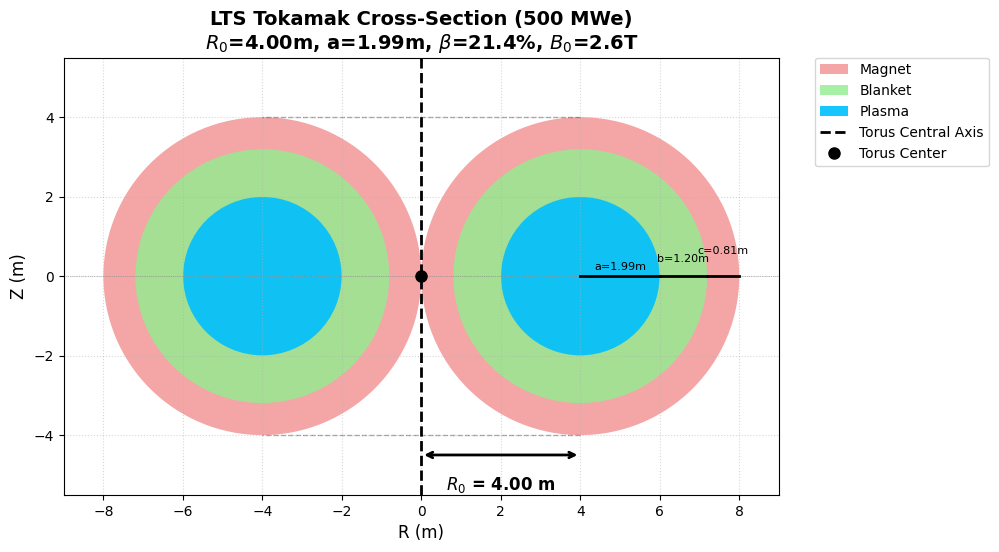

3D 시각화가 'fusion_reactor_3d_LTS_500MW.png' 파일로 저장되었습니다.


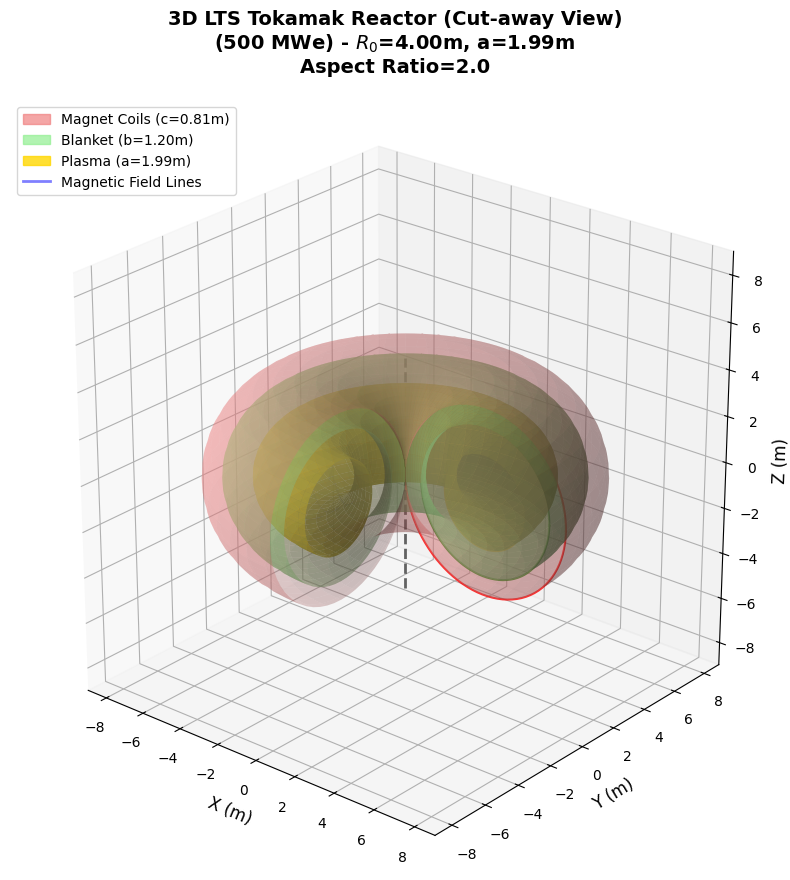

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection # 3D 채우기를 위해 추가

def calculate_fusion_reactor_design():
    """
    사용자와 상호작용하여 핵융합로 설계를 계산하고 결과를 출력 및 시각화하는 메인 함수.
    """
    # --- 물리 및 공학 상수 ---
    CONSTANTS = {
        'mu0': 4 * np.pi * 1e-7,  # 진공 투자율 (H/m)
        'b': 1.2,  # 블랭킷 및 차폐층 두께 (m)
        'Pw_max': 6.0e6,  # 최대 중성자 벽 부하 (W/m^2)
        'eta_t': 0.4,  # 열 변환 효율
        'energy_ratio': (14.1 + 3.5) / (14.1 + 3.5 + 4.8), # (E_n + E_alpha) / (E_n + E_alpha + E_Li)
        'p_tau_E_ignition': 8.3, # 점화 조건 (atm*s)
        'T_plasma_keV': 15.0, # 플라즈마 온도 (keV)
        'sigma_v_dt': 3.0e-22, # D-T 반응 단면적 (m^3/s at 15 keV)
        'eV_to_J': 1.602e-19, # eV to Joule 변환
        'atm_to_Pa': 101325, # atm to Pascal 변환
    }

    # --- 초전도체 기술별 제약 조건 ---
    SUPERCONDUCTOR_PROPS = {
        'LTS': {'B_max': 13.0, 'sigma_max': 300.0e6},
        'HTS': {'B_max': 25.0, 'sigma_max': 700.0e6}
    }

    # --- 사용자 입력 ---
    print("--- 핵융합로 설계 파라미터 입력 ---")
    try:
        P_E_MW = float(input("1. 원하는 전기 출력 (P_E)을 MW 단위로 입력하세요 (기본값: 1000): ") or 1000)
        P_E = P_E_MW * 1e6 # Watts
    except ValueError:
        print("잘못된 입력입니다. 기본값 1000 MW를 사용합니다.")
        P_E_MW = 1000
        P_E = P_E_MW * 1e6

    sc_type = ''
    while sc_type.upper() not in ['LTS', 'HTS']:
        sc_type = input("2. 초전도체 종류를 선택하세요 (LTS 또는 HTS): ")
    sc_type = sc_type.upper()

    use_defaults = input(f"3. {sc_type}의 기본 제약 조건(B_max={SUPERCONDUCTOR_PROPS[sc_type]['B_max']} T, sigma_max={SUPERCONDUCTOR_PROPS[sc_type]['sigma_max']/1e6} MPa)을 사용하시겠습니까? (y/n): ").lower()

    if use_defaults == 'n':
        try:
            B_max = float(input(f"   - 사용자 정의 B_max (T) 입력: "))
            sigma_max = float(input(f"   - 사용자 정의 sigma_max (MPa) 입력: ")) * 1e6
        except ValueError:
            print("잘못된 입력입니다. 기본값을 사용합니다.")
            B_max = SUPERCONDUCTOR_PROPS[sc_type]['B_max']
            sigma_max = SUPERCONDUCTOR_PROPS[sc_type]['sigma_max']
    else:
        B_max = SUPERCONDUCTOR_PROPS[sc_type]['B_max']
        sigma_max = SUPERCONDUCTOR_PROPS[sc_type]['sigma_max']

    # --- 계산 시작 ---
    print("\n--- 설계 계산을 시작합니다 ---")

    # 1. 기술 성능 지수 (xi) 계산
    xi = B_max**2 / (4 * CONSTANTS['mu0'] * sigma_max)

    # 2. 최적 기하학적 구조 (a, c) 계산 (Freidberg Eq. 5.29, 5.30)
    b = CONSTANTS['b']
    a = ((1 + xi) / (2 * np.sqrt(xi))) * b
    c = (np.sqrt(xi) * (1 + np.sqrt(xi))) / (1 - np.sqrt(xi)) * b

    # 3. 주 반경 (R0) 계산 (Freidberg Eq. 5.20, 5.32), 파워에 따른 R0 계산이지만, 요구 파워량을 줄이면 겹침이 생김.
    """
    # R0 = 0.04 * P_E / (a * Pw_max)

    """
    R0_coeff = (1 / (4 * np.pi**2 * CONSTANTS['eta_t'])) * (14.1 / (3.5 + 14.1 + 4.8))
    R0a = R0_coeff * P_E / CONSTANTS['Pw_max']
    print(f"MInimum R0 * a = {R0a}")

    # # ESY 20251111
    R0 = R0a/a
    if R0 < a+b+c :
      print(f"Since R0 ({R0}) from Min (R0*a) is less than a+b+c ({a+b+c}), we set R0 = a+b+c.\nNote that in this case, we don't have space for solenoid.")
      R0 = a+b+c

    # # 겹침 방지를 위해 R0 계산시 iter like 한 R0 적용.
    # R0 = 3.1*(a)

    # 4. 플라즈마 부피 및 표면적 계산
    V_p = 2 * np.pi**2 * R0 * a**2
    A_p = 4 * np.pi**2 * R0 * a

    # 5. 핵융합 출력 및 압력 계산
    P_alpha_plus_neutron_density = (CONSTANTS['energy_ratio'] / CONSTANTS['eta_t']) * (P_E / V_p)
    E_sum_J = (3.5 + 14.1) * 1e6 * CONSTANTS['eV_to_J']
    T_keV = CONSTANTS['T_plasma_keV']
    T_J = T_keV * 1e3 * CONSTANTS['eV_to_J']

    p_Pa = (16 * P_alpha_plus_neutron_density / E_sum_J)**0.5 * (T_J**2 / CONSTANTS['sigma_v_dt'])**0.5
    p_atm = p_Pa / CONSTANTS['atm_to_Pa']

    # 플라즈마 밀도 계산 (p = 2nkT)
    n = p_Pa / (2 * T_J)

    # 6. 요구되는 물리 성능 (tau_E, B0, beta) 계산
    tau_E = CONSTANTS['p_tau_E_ignition'] / p_atm
    B0 = B_max * (R0 - a - b) / R0
    beta = p_Pa / (B0**2 / (2 * CONSTANTS['mu0']))

    # 7. 경제성 및 공학 지표 계산
    V_I_per_PE_coeff = 1.58 * (1 + xi) / (1 - np.sqrt(xi))**2
    V_I_per_PE = V_I_per_PE_coeff * b / CONSTANTS['Pw_max']
    V_I = 2 * np.pi**2 * R0 * ((a + b + c)**2 - a**2)
    mass_I = V_I * 3000 # kg, using density from Problem 5.4

    # --- 결과 출력 ---
    design_params = {
        'P_E_MW': P_E_MW, 'sc_type': sc_type, 'B_max': B_max, 'sigma_max': sigma_max,
        'b': b, 'c': c, 'a': a, 'R0': R0,
        'aspect_ratio': R0 / a, 'A_p': A_p, 'V_p': V_p,
        'power_density': P_alpha_plus_neutron_density / 1e6,
        'B0': B0, 'p_atm': p_atm, 'T_keV': T_keV, 'n': n,
        'tau_E': tau_E, 'beta': beta * 100,
        'xi': xi, 'V_I_per_PE': V_I_per_PE, 'V_I': V_I, 'mass_I_tonnes': mass_I / 1000
    }

    print("\n--- 최종 설계 결과 ---")
    print(f"{'파라미터':<30} | {'값':<20}")
    print("-" * 52)
    print(f"{'입력 조건':<30} |")
    print(f"{'  전기 출력 (P_E)':<28} | {design_params['P_E_MW']:.0f} MW")
    print(f"{'  초전도체 종류':<28} | {design_params['sc_type']}")
    print(f"{'  최대 자기장 (B_max)':<28} | {design_params['B_max']:.1f} T")
    print(f"{'  최대 응력 (sigma_max)':<28} | {design_params['sigma_max']/1e6:.0f} MPa")
    print("-" * 52)
    print(f"{'기하학적 구조':<30} |")
    print(f"{'  블랭킷 두께 (b)':<28} | {design_params['b']:.2f} m")
    print(f"{'  코일 두께 (c)':<28} | {design_params['c']:.2f} m")
    print(f"{'  플라즈마 부반경 (a)':<28} | {design_params['a']:.2f} m")
    print(f"{'  주 반경 (R0)':<28} | {design_params['R0']:.2f} m")
    print(f"{'  종횡비 (R0/a)':<28} | {design_params['aspect_ratio']:.2f}")
    print(f"{'  플라즈마 표면적 (A_p)':<28} | {design_params['A_p']:.0f} m^2")
    print(f"{'  플라즈마 부피 (V_p)':<28} | {design_params['V_p']:.0f} m^3")
    print("-" * 52)
    print(f"{'성능':<30} |")
    print(f"{'  핵융합 출력 밀도':<28} | {design_params['power_density']:.2f} MW/m^3")
    print(f"{'  축상 자기장 (B0)':<28} | {design_params['B0']:.2f} T")
    print(f"{'  플라즈마 압력 (p)':<28} | {design_params['p_atm']:.2f} atm")
    print(f"{'  플라즈마 온도 (T)':<28} | {design_params['T_keV']:.0f} keV")
    print(f"{'  플라즈마 밀도 (n)':<28} | {design_params['n']:.2e} m^-3")
    print(f"{'  요구 에너지 가둠 시간 (tau_E)':<28} | {design_params['tau_E']:.2f} s")
    print(f"{'  요구 베타 (beta)':<28} | {design_params['beta']:.2f} %")
    print("-" * 52)
    print(f"{'경제성 및 공학 지표':<30} |")
    print(f"{'  기술 성능 지수 (xi)':<28} | {design_params['xi']:.3f}")
    print(f"{'  비용 지수 (V_I/P_E)':<28} | {design_params['V_I_per_PE']:.2f} m^3/MW")
    print(f"{'  총 공학적 부피 (V_I)':<28} | {design_params['V_I']:.0f} m^3")
    print(f"{'  총 질량 (근사치)':<28} | {design_params['mass_I_tonnes']:.0f} tonnes")
    print("-" * 52)

    # --- 시각화 ---
    plot_cross_section_double(R0, a, b, c, design_params)
    plot_3d_tokamak(R0, a, b, c, design_params)


def plot_cross_section_double(R0, a, b, c, params):
    """
    토러스를 반으로 잘라서 두 개의 원형 단면이 보이도록 하는 2D 시각화
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_aspect('equal')

    # 좌측 단면 (토러스의 한쪽)
    x_left = R0
    magnet_left = patches.Circle((x_left, 0), a + b + c, facecolor='lightcoral', alpha=0.7, label='Magnet')
    blanket_left = patches.Circle((x_left, 0), a + b, facecolor='lightgreen', alpha=0.8, label='Blanket')
    plasma_left = patches.Circle((x_left, 0), a, facecolor='deepskyblue', alpha=0.9, label='Plasma')

    # 우측 단면 (토러스의 반대쪽)
    x_right = -R0
    magnet_right = patches.Circle((x_right, 0), a + b + c, facecolor='lightcoral', alpha=0.7)
    blanket_right = patches.Circle((x_right, 0), a + b, facecolor='lightgreen', alpha=0.8)
    plasma_right = patches.Circle((x_right, 0), a, facecolor='deepskyblue', alpha=0.9)

    # 패치 추가
    ax.add_patch(magnet_left)
    ax.add_patch(blanket_left)
    ax.add_patch(plasma_left)
    ax.add_patch(magnet_right)
    ax.add_patch(blanket_right)
    ax.add_patch(plasma_right)

    # 중심축 및 토러스 중심 표시
    ax.axvline(0, color='black', linestyle='--', linewidth=2, label='Torus Central Axis')
    ax.axhline(0, color='gray', linestyle=':', linewidth=0.5)

    # 토러스 중심점 표시
    ax.plot(0, 0, 'ko', markersize=8, label='Torus Center')

    # 치수선 및 레이블
    ax.annotate('', xy=(0, -a-b-c-0.5), xytext=(R0, -a-b-c-0.5),
                arrowprops=dict(arrowstyle='<->', color='black', lw=2))
    ax.text(R0/2, -a-b-c-1.0, f'$R_0$ = {R0:.2f} m', ha='center', va='top', fontsize=12, fontweight='bold')

    y_pos = 0
    ax.plot([x_left, x_left + a], [y_pos, y_pos], 'k-', linewidth=2)
    ax.text(x_left + a/2, y_pos + 0.1, f'a={a:.2f}m', ha='center', va='bottom', fontsize=8)

    ax.plot([x_left + a, x_left + a + b], [y_pos, y_pos], 'k-', linewidth=2)
    ax.text(x_left + a + b/2, y_pos + 0.3, f'b={b:.2f}m', ha='center', va='bottom', fontsize=8)

    ax.plot([x_left + a + b, x_left + a + b + c], [y_pos, y_pos], 'k-', linewidth=2)
    ax.text(x_left + a + b + c/2, y_pos + 0.5, f'c={c:.2f}m', ha='center', va='bottom', fontsize=8)

    theta = np.linspace(0, np.pi, 100)
    x_top = R0 * np.cos(theta)
    y_top = (a + b + c) * np.ones_like(theta)
    x_bottom = R0 * np.cos(theta)
    y_bottom = -(a + b + c) * np.ones_like(theta)

    ax.plot(x_top, y_top, 'k--', alpha=0.3, linewidth=1)
    ax.plot(x_bottom, y_bottom, 'k--', alpha=0.3, linewidth=1)

    # 플롯 설정
    ax.set_xlim(-(R0 + a + b + c + 1), R0 + a + b + c + 1)
    ax.set_ylim(-(a + b + c + 1.5), a + b + c + 1.5)
    ax.set_xlabel("R (m)", fontsize=12)
    ax.set_ylabel("Z (m)", fontsize=12)

    title = (f"{params['sc_type']} Tokamak Cross-Section ({params['P_E_MW']:.0f} MWe)\n"
             f"$R_0$={params['R0']:.2f}m, a={params['a']:.2f}m, $\\beta$={params['beta']:.1f}%, $B_0$={params['B0']:.1f}T")
    ax.set_title(title, fontsize=14, fontweight='bold')

    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    filename = f"fusion_reactor_2d_{params['sc_type']}_{params['P_E_MW']:.0f}MW.png"
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"\n2D 단면도가 '{filename}' 파일로 저장되었습니다.")
    plt.show()


def plot_3d_tokamak(R0, a, b, c, params):
    """
    토카막의 3D 시각화 - 실제 비율과 내부 구조 표시 (오류 수정 및 축척 개선)
    """
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # 토러스 생성을 위한 각도 배열 (toroidal 방향으로 일부만 표시하여 단면 노출)
    u = np.linspace(0, 3 * np.pi / 2, 80)  # toroidal angle (3/4만 표시)
    v = np.linspace(0, 2 * np.pi, 60)  # poloidal angle
    U, V = np.meshgrid(u, v)

    # 파라미터 방정식으로 토러스 표면 정의
    X_plasma = (R0 + a * np.cos(V)) * np.cos(U)
    Y_plasma = (R0 + a * np.cos(V)) * np.sin(U)
    Z_plasma = a * np.sin(V)

    X_blanket = (R0 + (a + b) * np.cos(V)) * np.cos(U)
    Y_blanket = (R0 + (a + b) * np.cos(V)) * np.sin(U)
    Z_blanket = (a + b) * np.sin(V)

    X_magnet = (R0 + (a + b + c) * np.cos(V)) * np.cos(U)
    Y_magnet = (R0 + (a + b + c) * np.cos(V)) * np.sin(U)
    Z_magnet = (a + b + c) * np.sin(V)

    # 표면 그리기
    ax.plot_surface(X_magnet, Y_magnet, Z_magnet, color='lightcoral', alpha=0.3)
    ax.plot_surface(X_blanket, Y_blanket, Z_blanket, color='lightgreen', alpha=0.5)
    ax.plot_surface(X_plasma, Y_plasma, Z_plasma, color='gold', alpha=0.9)

    # 단면을 보여주기 위한 절단면 윤곽선 추가 (Y=0 평면)
    theta_cut = np.linspace(0, 2 * np.pi, 100)

    # 절단면이 시작하는 지점 (u=0)
    x_center_start = R0
    y_cut_start = np.zeros_like(theta_cut)

    # 자석
    x_magnet_start = x_center_start + (a + b + c) * np.cos(theta_cut)
    z_magnet_start = (a + b + c) * np.sin(theta_cut)
    ax.plot(x_magnet_start, y_cut_start, z_magnet_start, 'r-', linewidth=1.5, alpha=0.8)

    # 블랭킷
    x_blanket_start = x_center_start + (a + b) * np.cos(theta_cut)
    z_blanket_start = (a + b) * np.sin(theta_cut)
    ax.plot(x_blanket_start, y_cut_start, z_blanket_start, 'g-', linewidth=1.5, alpha=0.8)

    # 플라즈마
    x_plasma_start = x_center_start + a * np.cos(theta_cut)
    z_plasma_start = a * np.sin(theta_cut)
    ax.plot(x_plasma_start, y_cut_start, z_plasma_start, 'orange', linewidth=1.5, alpha=0.9)

    # --- 오류 수정: ax.fill 대신 Poly3DCollection 사용 ---
    # 절단면을 색으로 채우기
    # 자석 코일 영역
    verts_magnet = [list(zip(x_magnet_start, y_cut_start, z_magnet_start))]
    ax.add_collection3d(Poly3DCollection(verts_magnet, facecolors='lightcoral', alpha=0.3))
    # 블랭킷 영역
    verts_blanket = [list(zip(x_blanket_start, y_cut_start, z_blanket_start))]
    ax.add_collection3d(Poly3DCollection(verts_blanket, facecolors='lightgreen', alpha=0.5))
    # 플라즈마 영역
    verts_plasma = [list(zip(x_plasma_start, y_cut_start, z_plasma_start))]
    ax.add_collection3d(Poly3DCollection(verts_plasma, facecolors='gold', alpha=0.7))

    # 자기장 라인
    theta_field = np.linspace(0, 3 * np.pi / 2, 200)
    for r_field_factor in [-0.5, 0, 0.5]:
        r_field = R0 + r_field_factor * a
        x_field = r_field * np.cos(theta_field)
        y_field = r_field * np.sin(theta_field)
        z_field = 0.2 * a * np.sin(8 * theta_field)
        ax.plot(x_field, y_field, z_field, 'b-', alpha=0.3, linewidth=1)

    # 중심축 표시 (Z축)
    z_axis_range = a + b + c + 1
    ax.plot([0, 0], [0, 0], [-z_axis_range, z_axis_range], 'k--', linewidth=2, alpha=0.6)

    # 가장 바깥쪽 반경을 기준으로 축 범위를 설정
    max_range = R0 + a + b + c + 1

    # 각 축의 범위를 동일하게 설정하여 왜곡 방지
    ax.set_xlim(-max_range, max_range)
    ax.set_ylim(-max_range, max_range)
    ax.set_zlim(-max_range, max_range)

    # 3D 축의 시각적 비율을 1:1:1로 설정
    ax.set_box_aspect((1, 1, 1))

    ax.set_xlabel('X (m)', fontsize=12)
    ax.set_ylabel('Y (m)', fontsize=12)
    ax.set_zlabel('Z (m)', fontsize=12)

    title = (f"3D {params['sc_type']} Tokamak Reactor (Cut-away View)\n"
             f"({params['P_E_MW']:.0f} MWe) - $R_0$={params['R0']:.2f}m, a={params['a']:.2f}m\n"
             f"Aspect Ratio={params['aspect_ratio']:.1f}")
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)

    # 시점 설정 (절단면 고려)
    ax.view_init(elev=25, azim=-50)

    # 범례
    magnet_patch = patches.Patch(color='lightcoral', alpha=0.7, label=f'Magnet Coils (c={c:.2f}m)')
    blanket_patch = patches.Patch(color='lightgreen', alpha=0.7, label=f'Blanket (b={b:.2f}m)')
    plasma_patch = patches.Patch(color='gold', alpha=0.8, label=f'Plasma (a={a:.2f}m)')
    field_line = plt.Line2D([0], [0], color='blue', lw=2, alpha=0.5, label='Magnetic Field Lines')
    ax.legend(handles=[magnet_patch, blanket_patch, plasma_patch, field_line], loc='upper left')

    ax.grid(True, alpha=0.3)

    filename_3d = f"fusion_reactor_3d_{params['sc_type']}_{params['P_E_MW']:.0f}MW.png"
    plt.savefig(filename_3d, dpi=150, bbox_inches='tight')
    print(f"3D 시각화가 '{filename_3d}' 파일로 저장되었습니다.")
    plt.show()

if __name__ == '__main__':
    calculate_fusion_reactor_design()